## Image Search Series Part II: Zero-Shot 3D Image Search with MedImageInsight (MI2) ## 

This tutorial demonstrates how to build a **Zero-Shot 3D Image Search System** using **MedImageInsight (MI2) embeddings**.

### Data
This tutorial uses the **3D-MIR dataset**, designed for **organ lesion detection** and **severity assessment**, with a particular focus on evaluating **pancreatic lesions**. The dataset is organized into distinct **training** and **testing** splits to facilitate the development and evaluation of the 3D image search system. 

Please see the [README](../../../README.md) for more details on downloading the data.

#### 1. 3D-MIR Labels  
The **3D-MIR labels** provide essential information for identifying and categorizing organ lesions across pancreas, liver, lung and colon. Each labeled entry includes:

- **Lesion Group Classification** — Categorizing lesions based on size and severity.  

These lesion group labels are crucial for training and evaluating the 3D image search system, enabling accurate retrieval based on lesion characteristics.  

**Pancreas Labels** — Located at: `/home/azureuser/data/healthcare-ai/advanced-3D-image-search/pancreas_labels.csv`  

For further details on the **3D-MIR benchmark** and labeling methodology, refer to this publication: [3D-MIR Benchmark](https://arxiv.org/abs/2311.13752).

#### 2. MSD Images  
The **Medical Segmentation Decathlon (MSD)** dataset is a widely recognized collection of medical imaging data designed for segmentation tasks. It includes:

- **CT Imaging Data** for multiple organs.  
- **Segmentation Masks** that outline anatomical structures and lesions.  

In this tutorial, the MSD dataset serves as the foundation for building the image retrieval system. It provides valuable imaging data for both training and testing.  

🔗 The MSD dataset can be downloaded from: [MSD Dataset](http://medicaldecathlon.com/).

#### 3. Pancreas Training and Testing Splits
The dataset is divided into two files for training and testing purposes:  
- **Training Split** — Located at `/home/azureuser/data/healthcare-ai/advanced-3D-image-search/pancreas_full_train_split.csv` (used as the retrieval database).  
- **Testing Split** — Located at `/home/azureuser/data/healthcare-ai/advanced-3D-image-search/pancreas_full_test_split.csv` (used for image queries).  

### Online Endpoint Deployment  
The **MedImageInsight (MI2) Model** is available for deployment through the **[Azure AI Model Catalog](https://azure.microsoft.com/en-us/products/ai-model-catalog)**, providing a straightforward way to access and use the model.  

For those preferring a programmatic approach, detailed instructions can be found in the dedicated **[deployment notebook](https://aka.ms/healthcare-ai-examples-mi2-deploy)**. This guide outlines the steps required to deploy the MI2 model efficiently via code.


### Environment  
1. Install the **healthcareai_toolkit** package from the root of the repository:  
   ```sh
      pip install ./package
   ```
2. Set up your `.env` file with the `DATA_ROOT` and `MI2_MODEL_ENDPOINT` parameters.
3. Install the **FAISS** library using:  
   ```sh
      conda install -c pytorch faiss-cpu
   ```

### FAISS (Facebook AI Similarity Search)  
[FAISS](https://github.com/facebookresearch/faiss) provides efficient algorithms for searching large sets of vectors, even those too large to fit in memory. It supports adding or removing individual vectors and computes exact distances between them. FAISS is perfect for building scalable image search systems like the one in this tutorial.

### 3D Image Search

This tutorial demonstrates how to build a system that retrieves similar 3D images using an **embedding model** and the **FAISS** library.

#### 🔍 How Does It Work?
We'll create a **vector index** using the FAISS library, which enables efficient similarity search. The process involves:

- Generating embeddings (vector representations) for 3D images.
- Building a FAISS index to store these embeddings.
- Querying the FAISS index with a new embedding (query vector) to retrieve the most similar images.

FAISS supports both **exact** and **approximate** nearest neighbor searches, allowing you to balance between speed and precision. In this tutorial, we’ll use nearest neighbor search to efficiently identify the most relevant images.

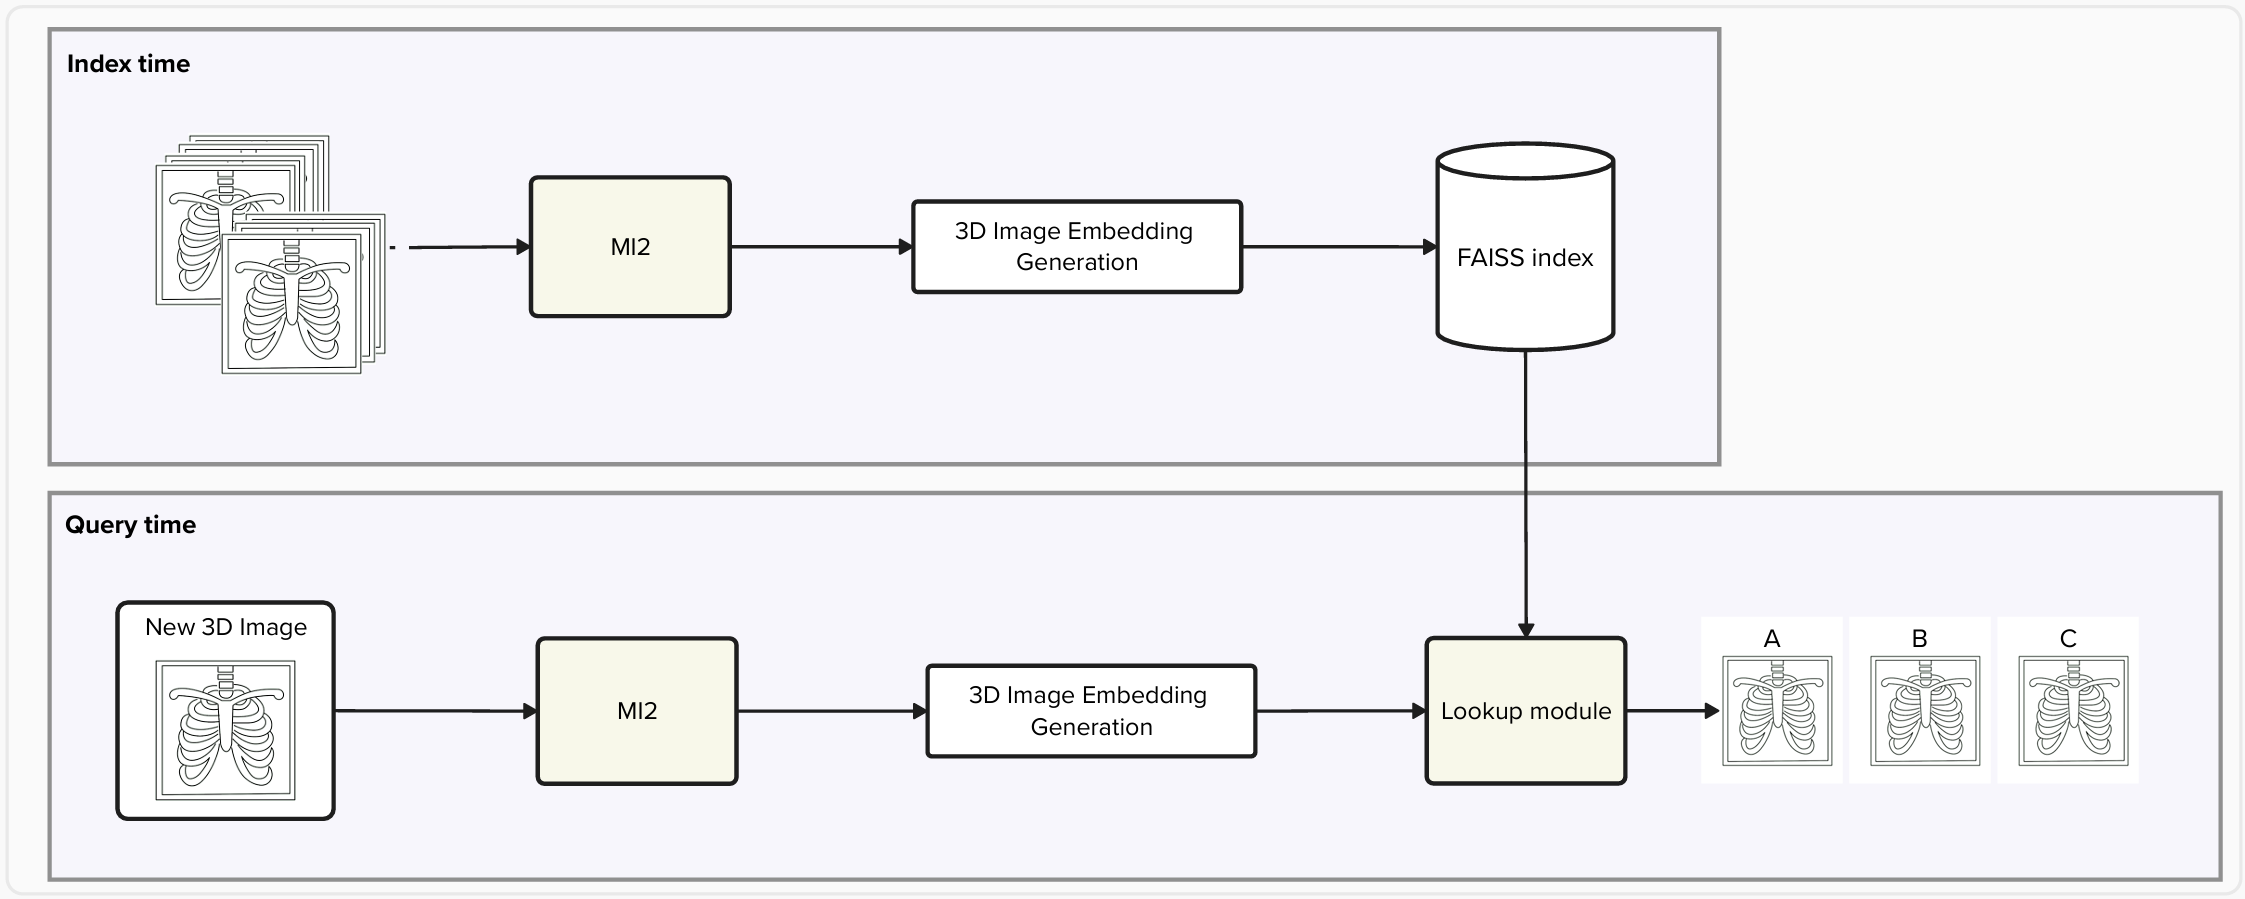

#### 🚀 Steps in this Tutorial

1. **Setup and Data Preparation**
   - Authenticate with **AzureML** and load the online **MI2** client.

2. **Compute Embeddings**
   - Generate **MI2 embeddings** for the images (2D slices of each volume) using the MI2 REST API endpoint.
      - ⚠️ **Note:** Pre-computed embeddings are available for convenience.
   - Aggregate the 2D embeddings to create **3D embeddings** for the full 3D volumes.

3. **Create a Search Model**
   - **Build a FAISS Index:**  
     - Create a FAISS index using the generated MI2 embeddings.
   - **Evaluate and Display Search Results:**  
     - Measure classification accuracy and calculate **precision @1**, **@3**, **@5** and **@10**.
     - Visualize query images alongside their retrieved neighbors to confirm accuracy.




## **1. Set up and data preparation**

In [ ]:
## Load Packages for the tutorial
import pandas as pd

pd.options.mode.chained_assignment = None
import glob
import pickle
import numpy as np
import os
from PIL import Image
import SimpleITK as sitk

sitk.ProcessObject_SetGlobalWarningDisplay(False)

from healthcareai_toolkit import settings
from healthcareai_toolkit.clients import MedImageInsightClient
from search_utils import create_faiss_index
from search_utils import evaluate_faiss_search
from search_utils import display_query_and_retrieved_images
from search_utils import check_pkl_files
from volume_utils import load_nifti_file, normalize_volume, convert_volume_to_slices

### Data Paths: Download the data files as described above and update the data paths below 

In [ ]:
##############################################################################
organ = "pancreas"
method = "median"  # All available methods: median/maxpooling/avgpooling/std
##############################################################################

data_path = "/home/azureuser/data/healthcare-ai/advanced-3D-image-search"

## Path to MSD images if you plan to generate embeddings
image_input_folder = ""

## Embeddings Folder
mi2_embd_test_set = f"{data_path}/mi2_test_embeddings"  ## test embeddings
mi2_embd_training_set = (
    f"{data_path}/mi2_training_embeddings"  ## training embeddings to create the index
)

## Quantification/Annotation File
quantification_csv = f"{data_path}/pancreas_labels.csv"

## Training & Test Sets
training_set_csv = f"{data_path}/" + organ + "_full_train_split.csv"
test_set_csv = f"{data_path}/" + organ + "_full_test_split.csv"

## Index Files
index_folder = f"{data_path}/index/" + organ + "-train-3d-index-" + method
## create new files
train_3d_index = index_folder + "/faiss_index_embd_train.index"
train_3d_index_tsv = index_folder + "/faiss_ids_embd_train.tsv"

## Images for Visualization
vis_folder = f"{data_path}/pancreas_tumor_label_overlay"

## Results Folders
results_dir = f"{data_path}/results/results_" + organ
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Ground-Truth Labels

In [ ]:
# Mapping image files with associated labels
aggregated_df = pd.read_csv(quantification_csv)
aggregated_df["file_name"] = aggregated_df["file_name"].replace(".nii.gz", "")
for i in range(len(aggregated_df["file_name"])):
    filename = aggregated_df["file_name"][i]
    aggregated_df["file_name"][i] = filename[: filename.index(".")]

## 2. 3D Embedding Generation
Embedding generation is implemented by extracting 2D slices from the 3D volume and generating embeddings for each slice. The embeddings are then aggregated to create a single embedding for the entire volume. This process is done using the MI2 model, which is a pre-trained model for generating embeddings for medical images.

In [4]:
aggregation_methods = {
    "maxpooling": lambda x: np.max(np.vstack(x), axis=0),
    "avgpooling": lambda x: np.mean(np.vstack(x), axis=0),
    "std": lambda x: np.std(np.vstack(x), axis=0),
    "median": lambda x: np.median(np.vstack(x), axis=0),
}
default_agg = lambda x: np.vstack(x)


def generate_3d_embeddings(
    submitter, subj_list, organ, input_dir, output_dir, method=None, save_feature=False
):
    """
    Generates embeddings for the MSD training or testing subjects.

    Args:
    - endpoint: MI2 endpoint
    - subj_list: list containing the training or testing subjects.
    - output_dir (str): Path to the directory containing the MSD images.
    - method (str): Pooling method for generating embeddings.

    Returns:
    - features (list): List of 1-D 3D embeddings.
    - img_names (list): List of subject names.
    """

    features = []
    img_names = []
    for id, subj in enumerate(subj_list):
        volume_path = input_dir + "/" + organ + "/" + subj + ".nii.gz"
        root_folder = os.path.dirname(os.path.abspath(volume_path))
        # Extract 2D slices from the 3D volume
        pngFolder = subj.split(".")[0] + "_png"
        output_png_dir = os.path.join(root_folder, pngFolder)
        ## create png files  / 2d slices
        if os.path.exists(output_png_dir) == False:
            os.makedirs(output_png_dir)
            subj_vol = load_nifti_file(volume_path)
            ## Perform 3D normalization
            subj_vol = normalize_volume(subj_vol)
            convert_volume_to_slices(subj_vol, output_png_dir, subj)
            # convert_volume_to_slices(volume_path, output_png_dir, subj)
            print("[{}] Converted {} into 2D slices!".format(id, subj))

        image_files = list(glob.glob(output_png_dir + "/*.png"))
        print(
            f"Generating a 3D embdeding vector to the {subj} volume with {len(image_files)} slices."
        )

        _, image_features_list = submitter.submit(
            image_list=image_files, total=len(image_files)
        )

        # for every item in image_features_list, get 'image_features' value and cast to numpy array
        image_features = [
            np.array(item["image_features"]) for item in image_features_list
        ]

        emb_3d = aggregation_methods.get(method, default_agg)(image_features)

        if save_feature == True:
            output_image_pkl = os.path.join(output_dir, subj + "_mi2_embedding.pkl")
            with open(output_image_pkl, "wb") as f:
                pickle.dump(emb_3d, f)
        print("Saved Image Feature as pkl file for Subject {}".format(subj))

        features.append(emb_3d)
        img_names.append(subj)
    return features, img_names

### Compute embeddings or load pre-computed embeddings
> ⚠️ Note that while we walk you through generating the embeddings from source files, we also provide pre-computed embeddings in .pkl files. 

We categorize the images into four groups based on the **3D-MIR benchmark**.  

- **Training Set:** The **Pancreas dataset**, which contains images with pancreatic lesions.  
- **Testing Set:** Images from the **liver**, **lung**, and **colon** datasets.  

The test images from the liver, lung, and colon datasets do **not** contain pancreatic lesions.

#### Training Set
**Check if every "training" image has an embeddings pkl file, load it if it exists. If not, generate MI2 embeddings and store them in a new pkl file.**

In [ ]:
# Connect to MI2 Endpoint
submit = False
if submit:
    mi2_client = MedImageInsightClient()
    submitter = mi2_client.create_submitter(n_jobs=2, return_as="list")

## Generate MI2 embeddings of the Training Set
train_df = pd.read_csv(training_set_csv)
train_embds_to_generate, train_subj_list = check_pkl_files(
    train_df, mi2_embd_training_set, train_test="training"
)

if len(os.listdir(mi2_embd_training_set)) == 0:
    print(
        f"----------Generating All {len(train_subj_list)} Embeddings for Training Set----------"
    )
    train_features, train_img_names = generate_3d_embeddings(
        submitter,
        train_subj_list,
        organ,
        image_input_folder,
        mi2_embd_training_set,
        method,
        save_feature=True,
    )
    print("----------Finished Generating Embeddings for Training Set----------")

elif len(train_embds_to_generate) != 0:
    print(
        f"----------Generating {len(train_embds_to_generate)} Missing Embeddings for Training Set----------"
    )
    train_features, train_img_names = generate_3d_embeddings(
        submitter,
        train_embds_to_generate,
        organ,
        image_input_folder,
        mi2_embd_training_set,
        method,
        save_feature=True,
    )
    print("----------Finished Generating Embeddings for Training Set----------")

else:
    print("Training embeddings available.")

Training embeddings available.


#### Test Set

**Check if every "test" image has an embeddings pkl file, load it if it exists. If not, generate MI2 embeddings and store them in a new pkl file.**

In [6]:
## Generate MI2 embeddings of the Test Set
test_df = pd.read_csv(test_set_csv)
test_embds_to_generate, test_subj_list = check_pkl_files(
    test_df, mi2_embd_test_set, train_test="testing"
)

# Generate embeddings
print(
    f"## Test Set: {len(test_embds_to_generate)} missing embedding file(s): {test_embds_to_generate}"
)
if len(os.listdir(mi2_embd_test_set)) == 0:
    print(
        f"----------Generating All {len(test_subj_list)} Embeddings for Test Set----------"
    )
    test_features, test_img_names = generate_3d_embeddings(
        submitter,
        test_subj_list,
        organ,
        image_input_folder,
        mi2_embd_test_set,
        method,
        save_feature=True,
    )
    print("----------Finished Generating Embeddings for Test Set----------")

elif len(test_embds_to_generate) != 0:
    print(
        f"----------Generating {test_embds_to_generate} Missing Embeddings for Test Set----------"
    )
    train_features, train_img_names = generate_3d_embeddings(
        submitter,
        test_embds_to_generate,
        organ,
        image_input_folder,
        mi2_embd_test_set,
        method,
        save_feature=True,
    )
    print("----------Finished Generating Embeddings for Test Set----------")

else:
    print("Test embeddings available.")

## Test Set: 0 missing embedding file(s): []
Test embeddings available.


#### Data Formatting and Lesion Group Criteria
We categorize **pancreatic conditions** into four distinct groups based on the presence, size, and number of lesions. This classification serves as a **baseline** for querying and retrieving similar pancreatic lesions in the dataset.

- **Healthy**: Images showing a **healthy pancreas** with **no visible lesions**.  
  - These cases provide important reference points for distinguishing normal anatomy from abnormal conditions.

- **Lesion Group 1**: Includes cases with a **single pancreatic lesion** that is **smaller than 2 cm**.  
  - This group typically represents early-stage or small lesions that may be easier to treat and have less impact on surrounding tissues.  

- **Lesion Group 2**: Includes cases with either:  
  - A **single pancreatic lesion** that is **larger than 2 cm**, or  
  - **Multiple pancreatic lesions**, where each individual lesion measures **≤ 5 cm**.  
  - This category reflects more complex cases with moderate lesion growth or multiple small lesions.

- **Lesion Group 3**: Includes cases with **one or more pancreatic lesions larger than 5 cm**.  
  - This group typically represents more advanced cases, where larger lesions may pose greater clinical challenges.

In [ ]:
# Remove column "Unnamed: 0" from original provided file
if "Unnamed: 0" in test_df.columns:
    test_df = test_df.drop(columns=["Unnamed: 0"])

# Rename column 'testing' to 'Name' to standardize and display results
test_df = test_df.rename(columns={"testing": "Name"})
test_df = test_df.rename(columns={"Stage": "Label"})


def map_label_to_category(df):
    """
    Maps label categories to their corresponding labels.
    """
    label_mapping = {
        -1: "Healthy",
        1: "Lesion Group 1",
        2: "Lesion Group 2",
        3: "Lesion Group 3",
    }
    df["Label Category"] = df["Label"].map(label_mapping)
    return df


# Map label categories to their corresponding labels
test_df = map_label_to_category(test_df)


# Create a new column '3d_embeddings', read pkl files from mi2_embd_test_set and match the file name with column 'Name'
test_df["3d_embedding"] = None

for i in range(len(test_df["Name"])):

    filename = test_df["Name"][i].replace("_mi2_embedding.pkl", "")
    embd_path = mi2_embd_test_set + "/" + filename + "_mi2_embedding.pkl"
    embd_path = embd_path.replace(".nii.gz", "")
    if os.path.exists(embd_path):
        with open(embd_path, "rb") as f:
            embd = pickle.load(f)
        test_df["3d_embedding"][i] = np.array(embd)
    else:
        print(f"File does not exist: {embd_path}")

## 3. Create a Search Model
### **Building the (3D) FAISS Index**

FAISS enables efficient similarity search by indexing vectors. When using **flat vectors**, FAISS stores each vector exactly and performs **exact nearest neighbor search** by comparing all vectors using a distance metric, such as **Euclidean distance**.

In this approach, vectors are stored in a **flat index** (`IndexFlatL2`), ensuring high precision by searching all vectors in memory. This method is ideal for smaller datasets, where search speed is less of a concern. While the flat index guarantees accurate results, it can be slower for large datasets due to the exhaustive comparison of each vector. This method is simple to implement and if it works for your use cases you might not even need the FAISS library for production implementation. 

For larger datasets, other indexing methods like **HNSW (Hierarchical Navigable Small World)** and **IVFPQ (Inverted File with Product Quantization)** can be used to approximate searches, improving speed while balancing precision. See more on [FAISS documentation pages](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index). 


In [8]:
## Embeddings of the Organ_training set
train_embs_list = []  # List of file paths with embeddings.

for img in train_df["training"]:
    img_emb = os.path.join(
        mi2_embd_training_set, img[: img.index(".")] + "_mi2_embedding.pkl"
    )
    train_embs_list.append(img_emb)


def aggregated_embeddings(aggregated_df, mi2_embd_training_set):
    # Create "3d_embedding" column in aggregated_df, then read pkl files in mi2_embd_training_set and add the embeddings to the column and match it to the file_name column
    aggregated_df["3d_embedding"] = None
    for i in range(len(aggregated_df["file_name"])):
        filename = aggregated_df["file_name"][i]
        embd_path = mi2_embd_training_set + "/" + filename + "_mi2_embedding.pkl"
        if os.path.exists(embd_path):
            with open(embd_path, "rb") as f:
                embd = pickle.load(f)
            aggregated_df["3d_embedding"][i] = embd
    aggregated_df["3d_embedding"] = aggregated_df["3d_embedding"].apply(
        lambda x: np.array(x)
    )

    # remove the rows with 3d_embedding = None
    aggregated_df = aggregated_df[aggregated_df["3d_embedding"].notna()]
    return aggregated_df


aggregated_df = aggregated_embeddings(aggregated_df, mi2_embd_training_set)

# Create the FAISS index
mi2_index = create_faiss_index(aggregated_df, "3d_embedding")

### Evaluate and Display Search Results

The performance of the image search engine is evaluated using several precision metrics: **Precision @1**, **Precision @3**, **Precision @5**, and **Precision @10**. These metrics measure how accurately the search engine retrieves relevant images based on their lesion group (label category).

These metrics provide insights into how effectively the system ranks relevant 3D images according to their condition labels (e.g., **Healthy**, **Lesion Group 1**, **Lesion Group 2**, or **Lesion Group 3**).

In addition to precision metrics, we also compute **overall precision** — a comprehensive measure that evaluates the model's performance across **all categories**.

The evaluation process follows these steps:

1. The system takes a set of images from the **test dataset**.  
2. For each test image, the system performs a **lookup** to retrieve the top matches.  
3. Accuracy is calculated by checking whether the **condition labels** in the retrieved results match those of the query image.  

⚠️ **Important Note:** The **MI2 model** generates embeddings based on a variety of imaging features. If your search system prioritizes different criteria — such as specific anatomical structures or certain imaging protocols — you may need to adjust the accuracy calculation accordingly to reflect those priorities.

In [9]:
# Rename column pancreas_lesion_group by Label
aggregated_df.rename(columns={"pancreas_lesion_group": "Label"}, inplace=True)
aggregated_df.rename(columns={"file_name": "Name"}, inplace=True)

# Create a column named LabelCategory with the values of Label
aggregated_df["Label Category"] = aggregated_df["Label"].astype(str)
map_label_to_category(aggregated_df)

k_list = [1, 3, 5]

mi2_summary_df, mi2_detail_df, mi2_search_results_df = evaluate_faiss_search(
    mi2_index,
    test_df,
    aggregated_df,
    k_list,
    query_column_feature_name="3d_embedding",
)

display(mi2_detail_df)
display(mi2_summary_df)

Label        Category  Precision @ k=1  Precision @ k=3  Precision @ k=5
0     -1         Healthy         1.000000         1.000000         1.000000
1      1  Lesion Group 1         0.000000         0.000000         0.133333
2      2  Lesion Group 2         0.684211         0.719298         0.715789
3      3  Lesion Group 3         0.333333         0.277778         0.233333

k (Top-K)  Overall Precision
0          1           0.504386
1          3           0.499269
2          5           0.520614

#### Display images and retrieved neighbors
Here, we visualize sample query images alongside their top five nearest neighbors. In each row, the first image is the query, followed by the retrieved images ranked by similarity. The visual overlays help in assessing retrieval accuracy; 
- **Blue**: indicates the **pancreas organ** boundaries, and 
- **Red**: highlights the mark regions corresponding to the **pancreas tumor**.


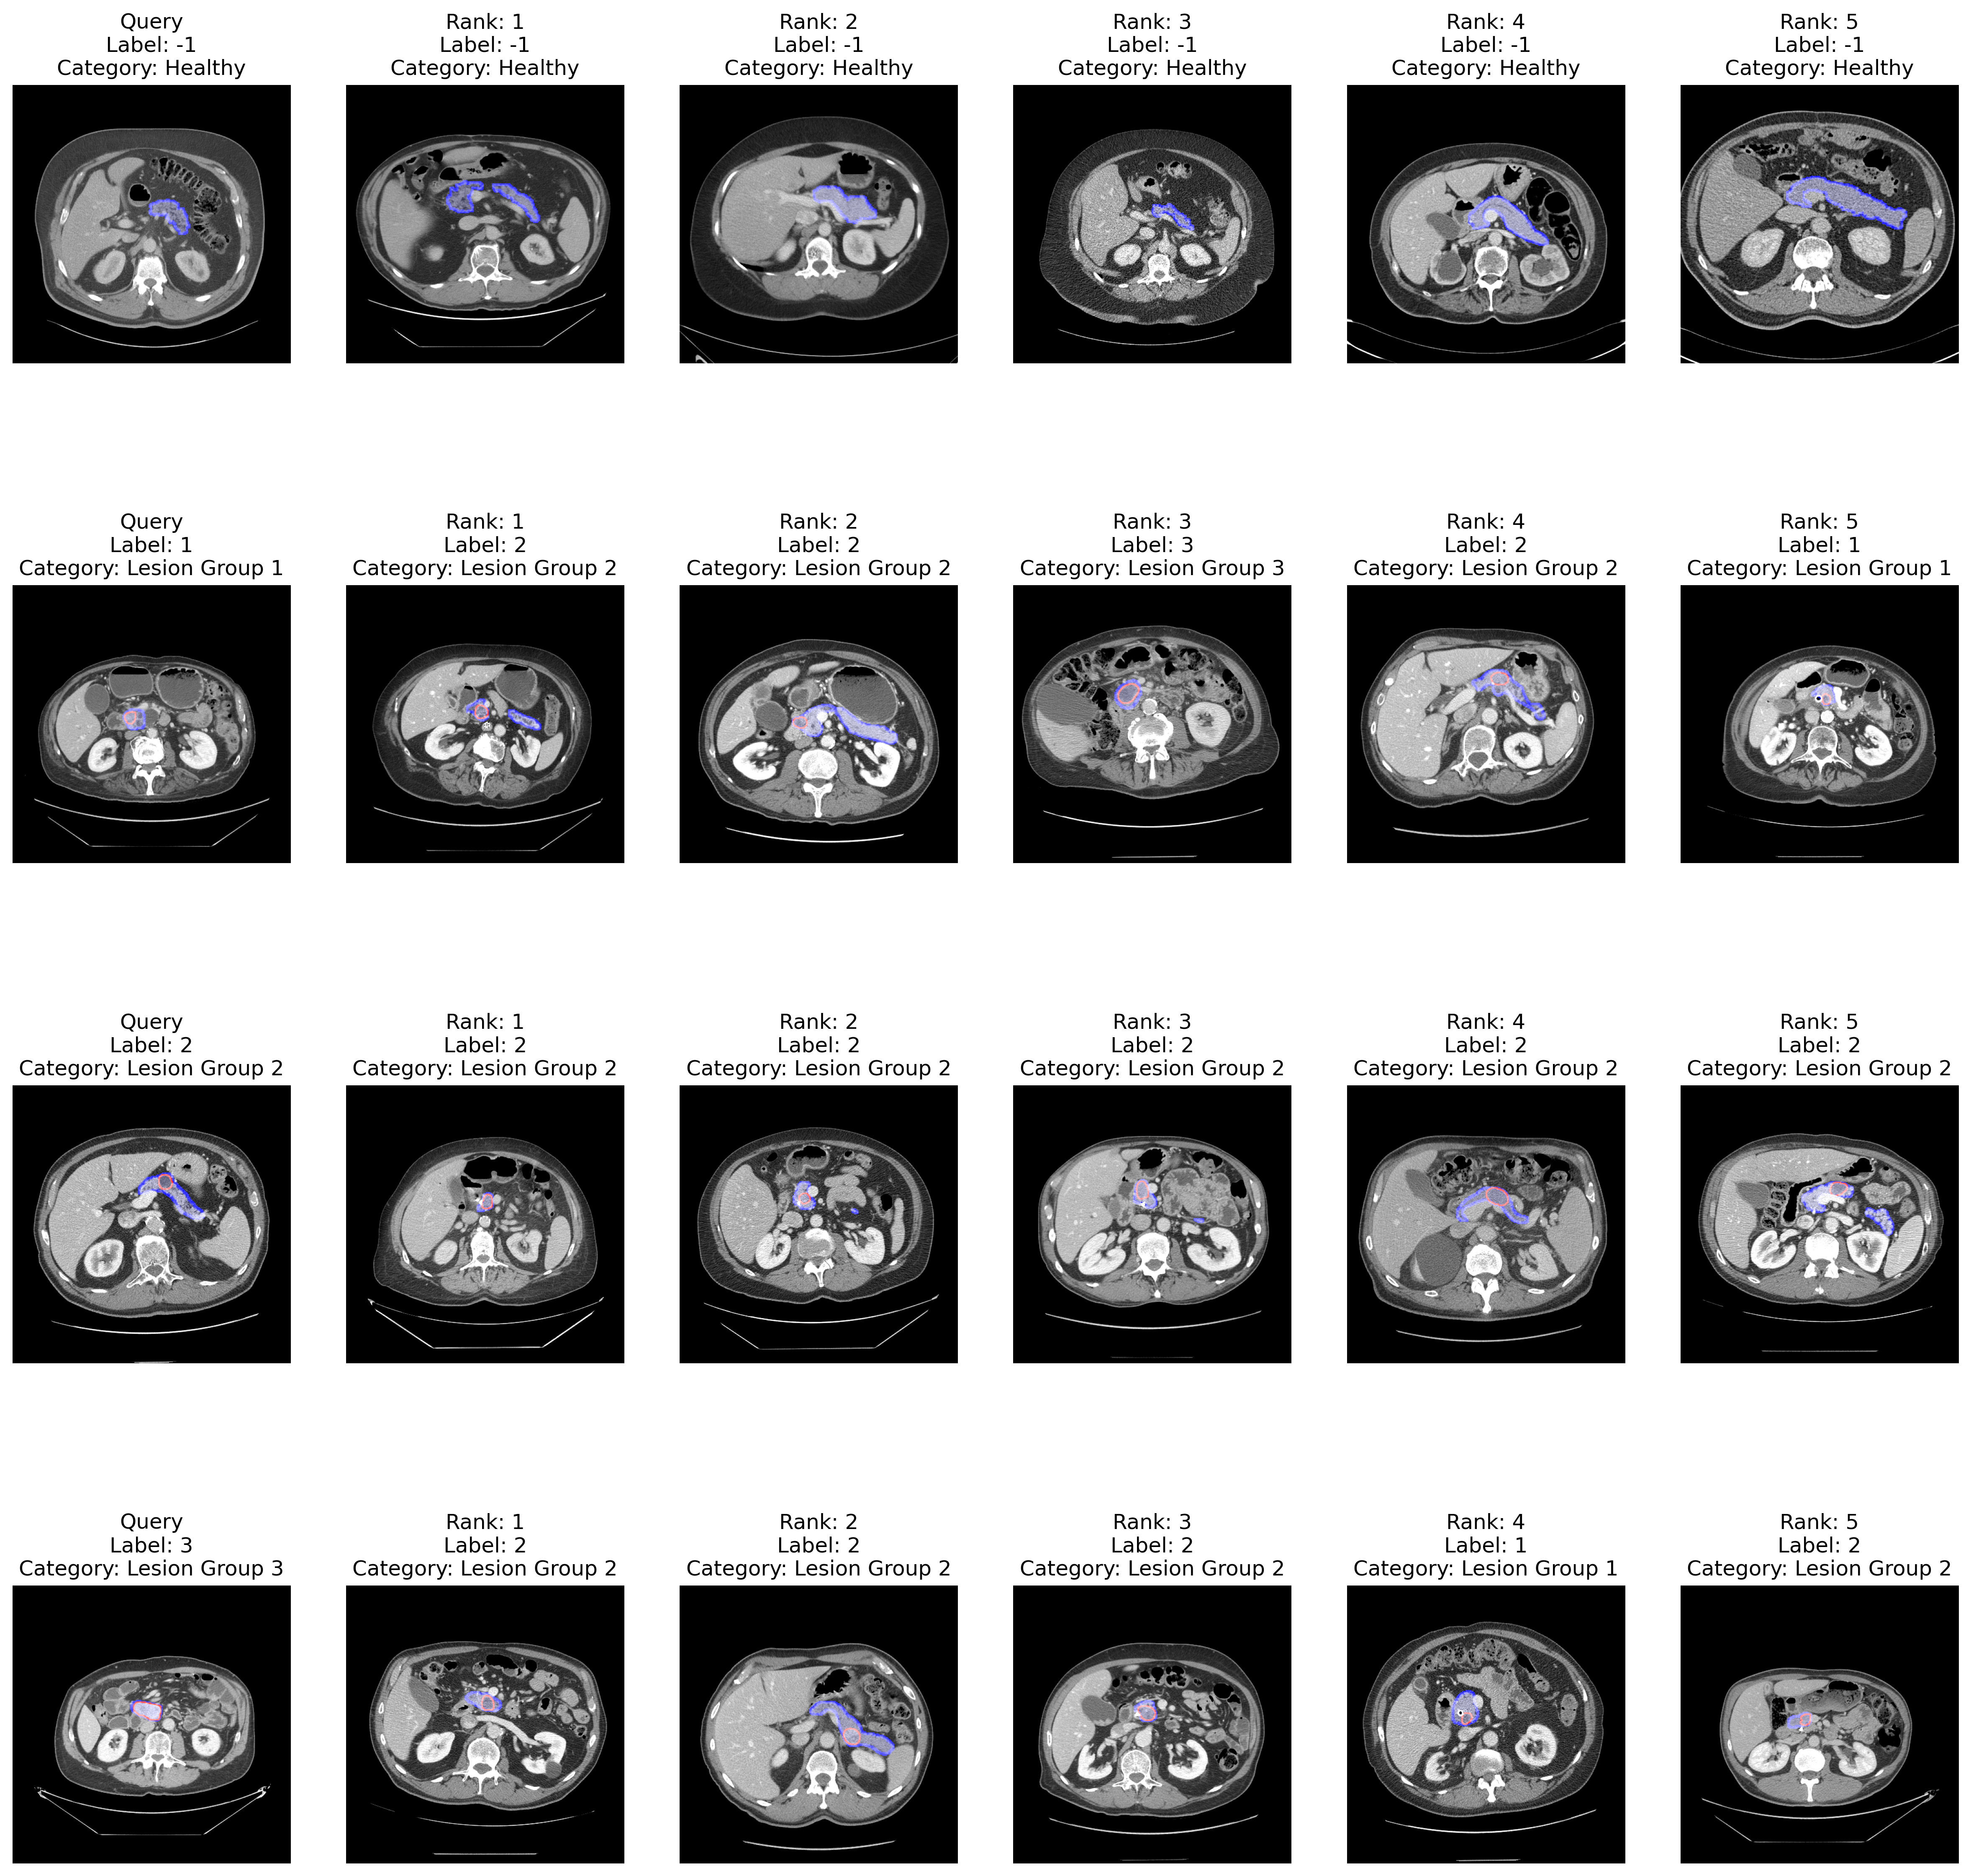

In [10]:
import warnings

warnings.filterwarnings("ignore", message="Squeezing the first dimension")

# Select one sample per label for visualization
query_df = test_df.groupby("Label").first().reset_index()

display_query_and_retrieved_images(
    query_df,
    mi2_search_results_df,
    vis_folder,
    aggregated_df,
    format="png",
    overlay=True,
)

## Key observations

The system **accurately recognizes Healthy cases**, consistently retrieving the correct label in test scenarios involving non-lesion pancreas images. However, **performance varies** for different lesion groups, reflecting challenges in precisely identifying smaller lesions (Group 1) or more advanced lesions (Group 3). This discrepancy highlights the **complexity of lesion detection** and underscores the importance of carefully **tuning embeddings** or **adjusting the FAISS index** to improve retrieval accuracy for specific lesion sizes.

These results are **illustrative** and mirror a use case akin to **lesion detection** and **severity measurement** in a clinical context. In real-world applications—such as **diagnostic support** or **treatment planning**—it may be necessary to **optimize the model** to account for particular goals (e.g., detecting critical lesions early) or accommodate different **imaging protocols**. By refining search criteria, integrating more domain-specific data, or adjusting embedding methods, practitioners can **enhance retrieval precision** and better meet clinical requirements.
